In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import scipy.stats as stats
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import functools
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(0, '../../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic
from roc_ps import get_shuffled_df, get_roc#all_func

#### Variables

In [3]:
top_path = 'C:/Users/morts/Documents/TAU/Manifold_Project/Data/Serrano_Ravel13_Ravel11_Carter22/ps_res/res_UMAP_without_srin/'

file_name = top_path + 'ps_res_16052023.xlsx'
nn_file_name = top_path + 'nn_res_30052023.xlsx'

sheet_abun = 'abundance'
sheet_meta = 'meta'
sheet_umap = 'umap'
sheet_pcoa = 'pcoa'

#### Load data

In [4]:
meta = pd.read_excel(file_name, sheet_name = sheet_meta, index_col = 0)
nn_meta = pd.read_excel(nn_file_name, sheet_name = sheet_meta, index_col = 0)
print(meta.shape)
print(nn_meta.shape)

(7842, 31)
(514, 35)


In [5]:
both_meta = pd.concat([meta, nn_meta])
temp_meta = both_meta[both_meta['db'] == "temp_pyro"]
# temp_meta = both_meta[both_meta['db'].str.contains("temp")]

#### View std

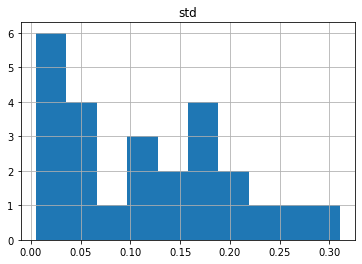

In [40]:
agg_df = temp_meta.groupby('subjectID')['mt_pseudotime'].aggregate(['std'])
agg_df.hist(column = 'std')
std_val = 0.08
high_std_subjects = agg_df[agg_df['std'] > std_val].index
filt_temp_meta = temp_meta[temp_meta['subjectID'].isin(high_std_subjects)]

#### Functions

In [80]:
def flatten_lst(lst):
    return [item for items in lst for item in items]

def select_df_by_indices(df, idx_lsts, bv_next, predict_group_size = 5):
    groups_names = [[i] * (predict_group_size - 1) for i, x in enumerate(idx_lsts)]
    flatten_idx_lst = flatten_lst(idx_lsts)
    flatten_names_lst = flatten_lst(groups_names)
    
    new_df = df.iloc[flatten_idx_lst]
    new_df['group_name'] = flatten_names_lst
    new_df['bv_next'] = bv_next
    
    return new_df

def get_grouped_by_bv(temp_meta, measured_col, predict_group_size, ascending = True):
    if ascending:
        temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, True]).reset_index()
        samples_idx = temp_meta_no[(temp_meta_no[measured_col] == 1) & (temp_meta_no['time'] > predict_group_size)].index
        before_lists = [list(range(num - (predict_group_size - 1), num)) for num in samples_idx]
    else:
        temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, False]).reset_index()
        samples_idx = temp_meta_no[(temp_meta_no[measured_col] == 1) & (temp_meta_no['time'] > predict_group_size)].index
        before_lists = [list(range(num - (predict_group_size - 1), num)) for num in samples_idx]
    before_df = select_df_by_indices(temp_meta_no, before_lists, 1, predict_group_size)
    
    return before_df

def get_trend_plot(before_df):
    groups_num = len(before_df.group_name.unique())
    nrow = 3
    ncol = groups_num // nrow
    fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6), constrained_layout=True)
    for group, ax in zip(before_df.group_name.unique(), axes.flat):
        plot_df = before_df[before_df['group_name'] == group]
        subject = plot_df.subjectID.unique()
        x = plot_df['time']
        y = plot_df['mt_pseudotime']
        ax.set_title(subject)
        ax.scatter(x, y)
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m * x + b, color='red')
    return fig

def all_func(temp_meta, measured_col, predict_group_size):
    before_df = get_grouped_by_bv(temp_meta, measured_col, predict_group_size)
    fig = get_trend_plot(before_df)
    
    return before_df, fig

#### Run

In [50]:
predict_group_size = 5
print(len(temp_meta[temp_meta['BV_bin'] == 1]))
print(len(temp_meta[(temp_meta['BV_bin'] == 1) & (temp_meta['time'] > predict_group_size)]))

31
20


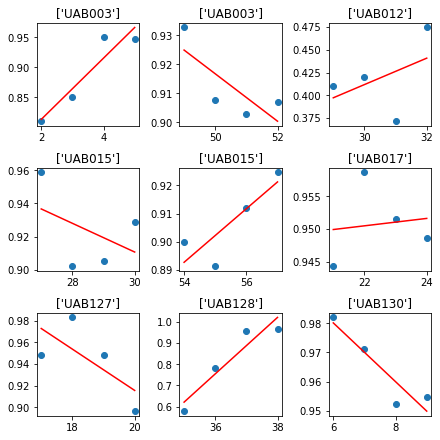

In [81]:
bv_before_df, fig = all_func(filt_temp_meta, 'BV_bin', predict_group_size)

In [ ]:
med_after_df, fig = all_func(filt_temp_meta, 'BV_medication', predict_group_size, ascending = False)

In [86]:
[num for i, num in enumerate(samples_idx) if num == samples_idx[i - 1] + 1 ]
# [num if num == samples_idx[i - 1] + 1 ]
samples_idx

Int64Index([   0,    1,    2,    4,    5,    6,   47,   48,   49,   50,   51,
              52,  112,  113,  114,  115,  116,  117,  329,  515,  516,  517,
             518,  519,  520,  521,  522,  523,  764,  765,  766,  767,  768,
             769,  770,  803,  804,  805,  806, 1350, 1351, 1352, 1353, 1354,
            1355, 1397, 1398, 1399, 1400, 1401, 1402, 1428, 1429, 1430, 1431,
            1432, 1433, 1434, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1529,
            1530, 1531, 1532, 1533, 1534],
           dtype='int64')

In [87]:
measured_col = 'BV_medication'
temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, False]).reset_index()
samples_idx = temp_meta_no[(temp_meta_no[measured_col] == 1) & (temp_meta_no['time'] > predict_group_size)].index
before_lists = [list(range(num, num + (predict_group_size - 1))) for num in samples_idx]
groups_names = [[i] * (predict_group_size - 1) for i, x in enumerate(samples_idx)]
print(samples_idx)
print(before_lists)
print(groups_names)
groups_names = [[i] * (predict_group_size - 1) for i, x in enumerate(before_lists)]
flatten_idx_lst = flatten_lst(before_lists)
flatten_names_lst = flatten_lst(groups_names)

new_df = temp_meta_no.iloc[flatten_idx_lst]
new_df['group_name'] = flatten_names_lst
new_df['bv_next'] = 1

Int64Index([   0,    1,    2,    4,    5,    6,   47,   48,   49,   50,   51,
              52,  112,  113,  114,  115,  116,  117,  329,  515,  516,  517,
             518,  519,  520,  521,  522,  523,  764,  765,  766,  767,  768,
             769,  770,  803,  804,  805,  806, 1350, 1351, 1352, 1353, 1354,
            1355, 1397, 1398, 1399, 1400, 1401, 1402, 1428, 1429, 1430, 1431,
            1432, 1433, 1434, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1529,
            1530, 1531, 1532, 1533, 1534],
           dtype='int64')
[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [47, 48, 49, 50], [48, 49, 50, 51], [49, 50, 51, 52], [50, 51, 52, 53], [51, 52, 53, 54], [52, 53, 54, 55], [112, 113, 114, 115], [113, 114, 115, 116], [114, 115, 116, 117], [115, 116, 117, 118], [116, 117, 118, 119], [117, 118, 119, 120], [329, 330, 331, 332], [515, 516, 517, 518], [516, 517, 518, 519], [517, 518, 519, 520], [518, 519, 520, 521], [519, 520, 521, 522], [520, 

In [75]:
temp_meta_no[['subjectID', 'time', 'BV_medication']]

,subjectID,time,BV_medication
0,UAB003,59.0,1.0
1,UAB003,58.0,1.0
2,UAB003,57.0,1.0
3,UAB003,56.0,0.0
4,UAB003,55.0,1.0
...,...,...,...
1568,UAB135,5.0,0.0
1569,UAB135,4.0,0.0
1570,UAB135,3.0,0.0
1571,UAB135,2.0,0.0


In [70]:
temp_meta_no

,index,sampleID,subjectID,day,week,time,ph,nugent,menst,subCST,...,BV_bin,root,dpt_pseudotime,mt_pseudotime,closest_sample,distance,closest_subCST,nugent_bin,ph_bin,BV_amsel_bin
0,SRR904058,UAB003_10_3,UAB003,3.0,10.0,59.0,4.0,NaN,NaN,III-B,...,0,reg,0.062693,0.937307,NaN,NaN,NaN,NaN,NaN,NaN
1,SRR904067,UAB003_10_2,UAB003,2.0,10.0,58.0,4.0,NaN,NaN,III-B,...,0,reg,0.069469,0.930531,NaN,NaN,NaN,NaN,NaN,NaN
2,SRR904066,UAB003_10_1,UAB003,1.0,10.0,57.0,4.0,NaN,NaN,III-B,...,0,reg,0.053770,0.946230,NaN,NaN,NaN,NaN,NaN,NaN
3,SRR904065,UAB003_9_7,UAB003,7.0,9.0,56.0,4.0,NaN,NaN,IV-B,...,0,reg,0.049709,0.950291,NaN,NaN,NaN,NaN,NaN,NaN
4,SRR904064,UAB003_9_6,UAB003,6.0,9.0,55.0,4.0,NaN,NaN,IV-B,...,0,reg,0.098093,0.901907,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,SRR906370,UAB135_1_5,UAB135,5.0,1.0,5.0,5.8,NaN,NaN,IV-B,...,0,reg,0.026997,0.973003,NaN,NaN,NaN,NaN,NaN,NaN
1569,SRR906369,UAB135_1_4,UAB135,4.0,1.0,4.0,5.3,NaN,NaN,IV-B,...,0,reg,0.029423,0.970577,NaN,NaN,NaN,NaN,NaN,NaN
1570,SRR906379,UAB135_1_3,UAB135,3.0,1.0,3.0,5.5,NaN,NaN,IV-B,...,0,reg,0.030028,0.969972,NaN,NaN,NaN,NaN,NaN,NaN
1571,SRR906368,UAB135_1_2,UAB135,2.0,1.0,2.0,5.3,NaN,1.0,IV-B,...,0,reg,0.029419,0.970581,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
temp_meta.groupby('subjectID')['BV_medication'].sum()

subjectID
UAB003    12.0
UAB005     6.0
UAB007     0.0
UAB012     0.0
UAB015     0.0
UAB017     1.0
UAB023     0.0
UAB027     0.0
UAB035     9.0
UAB040     0.0
UAB049     0.0
UAB052     0.0
UAB053     7.0
UAB055     4.0
UAB059     0.0
UAB060     0.0
UAB077     0.0
UAB082     0.0
UAB096     0.0
UAB112     0.0
UAB116     0.0
UAB127     6.0
UAB128    13.0
UAB130     7.0
UAB135     6.0
Name: BV_medication, dtype: float64

#### Order

##### BV

In [41]:
def flatten_lst(lst):
    return [item for items in lst for item in items]

def select_df_by_indices(df, idx_lsts, bv_next, predict_group_size = 5):
    groups_names = [[i] * (predict_group_size - 1) for i, x in enumerate(idx_lsts)]
    flatten_idx_lst = flatten_lst(idx_lsts)
    flatten_names_lst = flatten_lst(groups_names)
    
    new_df = df.iloc[flatten_idx_lst]
    new_df['group_name'] = flatten_names_lst
    new_df['bv_next'] = bv_next
    
    return new_df

In [49]:
temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, True]).reset_index()
bv_samples_idx = temp_meta_no[(temp_meta_no['BV_bin'] == 1) & (temp_meta_no['time'] > predict_group_size)].index
before_bv_lists = [list(range(num - (predict_group_size - 1), num)) for num in bv_samples_idx]
before_bv_df = select_df_by_indices(temp_meta_no, before_bv_lists, 1, predict_group_size)

###### Healthy

In [43]:
idx = (temp_meta_no['BV_bin'].rolling(window = predict_group_size).min() == 0).to_numpy()

In [ ]:
filterred_after_med_lists = []
for i, lst in enmerate(after_med_lists):
    common_set = set(after_med_lists[i]).intersection(after_med_lists[i + 1])
    if len(common_set) >= 1:
        filterred_after_med_lists.append(after_med_lists[i + 1])

In [201]:
import functools
lis = med_samples_idx
result = functools.reduce(lambda x,y : x[:-1]+[x[-1]+[y]] if (x[-1][-1]+1==y) else [*x,[y]], lis[1:] , [[med_samples_idx[0]]] )
high_result = [max(lst) for lst in result]
high_result

[2, 6, 52, 117, 329, 523, 770, 806, 1355, 1402, 1434, 1471, 1534]

In [143]:
temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, False]).reset_index()
med_samples_idx = temp_meta_no[(temp_meta_no['BV_medication'] == 1) & (temp_meta_no['time'] > predict_group_size)].index
after_med_lists = [list(range(num, num + (predict_group_size - 1))) for num in med_samples_idx]
after_med_df = select_df_by_indices(temp_meta_no, after_med_lists, 1, predict_group_size)
print(med_samples_idx)
print(after_med_lists)
# print(after_med_df)

Int64Index([   0,    1,    2,    4,    5,    6,   47,   48,   49,   50,   51,
              52,  112,  113,  114,  115,  116,  117,  329,  515,  516,  517,
             518,  519,  520,  521,  522,  523,  764,  765,  766,  767,  768,
             769,  770,  803,  804,  805,  806, 1350, 1351, 1352, 1353, 1354,
            1355, 1397, 1398, 1399, 1400, 1401, 1402, 1428, 1429, 1430, 1431,
            1432, 1433, 1434, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1529,
            1530, 1531, 1532, 1533, 1534],
           dtype='int64')
[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [47, 48, 49, 50], [48, 49, 50, 51], [49, 50, 51, 52], [50, 51, 52, 53], [51, 52, 53, 54], [52, 53, 54, 55], [112, 113, 114, 115], [113, 114, 115, 116], [114, 115, 116, 117], [115, 116, 117, 118], [116, 117, 118, 119], [117, 118, 119, 120], [329, 330, 331, 332], [515, 516, 517, 518], [516, 517, 518, 519], [517, 518, 519, 520], [518, 519, 520, 521], [519, 520, 521, 522], [520, 

In [ ]:
def ps_after(meta, obj_col, high_std_subjects, predict_group_size = 4):
    # Order by subjectID and time
    temp_meta = meta[(meta['db'] == 'temp_pyro') & meta['subjectID'].isin(high_std_subjects)]
    temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, False]).reset_index()
    temp_meta_no['cumcount_time'] = temp_meta_no.groupby(['subjectID']).cumcount().add(1)
    
    # Get indices of medication and after
    med_samples_idx = temp_meta_no[(temp_meta_no[obj_col] == 1) & (temp_meta_no['cumcount_time'] > predict_group_size)].index
    
    # Filter consecutive indices 
    filt_after_med_idx = functools.reduce(lambda x,y : x[:-1]+[x[-1]+[y]] if (x[-1][-1]+1==y) else [*x,[y]], med_samples_idx[1:] , [[med_samples_idx[0]]] )
    high_after_med_idx = [min(lst) for lst in filt_after_med_idx]
    
    # Get after samples and filter df
    after_med_lists = [list(range(num - 2, num + (predict_group_size))) for num in high_after_med_idx if num > predict_group_size - 1]
#     [list(range(num, num + (predict_group_size - 1))) for num in high_after_med_idx]
    after_med_df = select_df_by_indices(temp_meta_no, after_med_lists, predict_group_size = predict_group_size)
    
    return after_med_df, med_samples_idx, high_after_med_idx, after_med_lists

#### Plot trends

In [ ]:
temp_meta.BV_bin

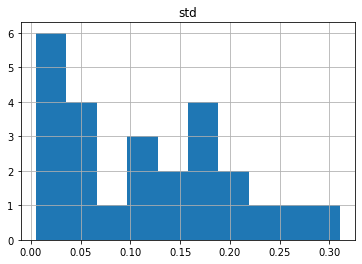

In [69]:
agg_df = temp_meta.groupby('subjectID')['mt_pseudotime'].aggregate(['std'])
agg_df.hist(column = 'std')
high_std_subjects = agg_df[agg_df['std'] > 0.05].index
filt_before_bv_df = before_bv_df[before_bv_df['subjectID'].isin(high_std_subjects)]
filt_after_med_df = after_med_df[after_med_df['subjectID'].isin(high_std_subjects)]

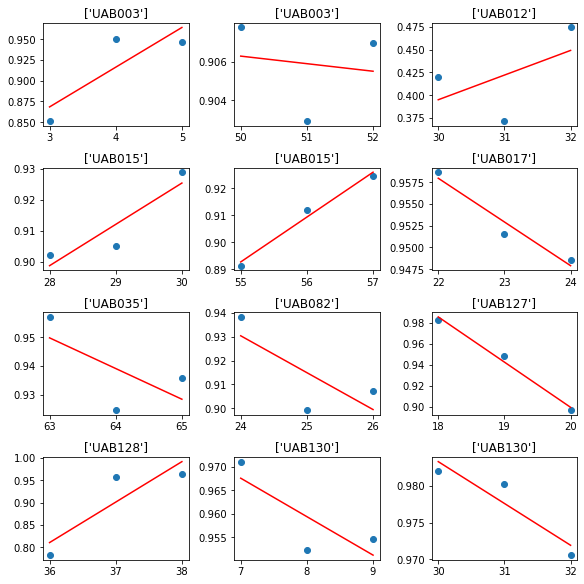

In [70]:
subjects_num = len(filt_before_bv_df.group_name.unique())
nrow = 4
ncol = subjects_num // nrow
fig, axes = plt.subplots(nrow, ncol, figsize=(8, 8), constrained_layout=True)
for group, ax in zip(filt_before_bv_df.group_name.unique(), axes.flat):
    plot_df = filt_before_bv_df[before_bv_df['group_name'] == group]
    subject = plot_df.subjectID.unique()
    x = plot_df['time']
    y = plot_df['mt_pseudotime']
    ax.set_title(subject)
    ax.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')

In [24]:
subjects_num = len(filt_after_med_df.group_name.unique())
nrow = 4
ncol = subjects_num // nrow
fig, axes = plt.subplots(nrow, ncol, figsize=(8, 8), constrained_layout=True)
for group, ax in zip(filt_after_med_df.group_name.unique(), axes.flat):
    plot_df = filt_after_med_df[before_bv_df['group_name'] == group]
    subject = plot_df.subjectID.unique()
    x = plot_df['time']
    y = plot_df['mt_pseudotime']
    ax.set_title(subject)
    ax.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')

16

#### ROC

In [187]:
def add_month(temp_meta):
    ord_temp_meta = temp_meta.sort_values(['subjectID', 'time'])
    ord_temp_meta = ord_temp_meta.merge(pd.DataFrame(ord_temp_meta.groupby("subjectID")['time'].max()), 
                        left_on = 'subjectID', right_index = True)
    ord_temp_meta.rename(columns = {'time_y':'time_max', 'time_x':'time'}, inplace = True)
    ord_temp_meta['time_max'] = ord_temp_meta['time_max'] // 2
    ord_temp_meta['monthly_time'] = np.where(ord_temp_meta['time'] < (ord_temp_meta['time_max']), '0', '1')
    ord_temp_meta['monthly_subjectID'] = ord_temp_meta['subjectID'] + '_' + ord_temp_meta['monthly_time'].astype(str)
    
    return ord_temp_meta

def add_bv_res(ord_temp_meta, group_col, head):
    ord_temp_meta = ord_temp_meta.sort_values([group_col, 'time'])
    head_df = ord_temp_meta.groupby(group_col).head(head)
    head_df = head_df.groupby(group_col).filter(lambda x: (x.BV_bin == 0).all())
    bv_res = ord_temp_meta.groupby(group_col)['BV_bin'].sum().to_frame(name = 'bv_res')
    bv_res[bv_res > 1] = 1
    grouped_head_df = head_df.groupby(group_col)['mt_pseudotime'].aggregate(['min', 'max', 'mean', 'std', 'median'])
    grouped_head_df = grouped_head_df.join(bv_res)
    
    return grouped_head_df

In [192]:
head = 5
ord_temp_meta = add_month(temp_meta)
grouped_head_df = add_bv_res(ord_temp_meta, 'monthly_subjectID', head)
grouped_head_df = add_bv_res(ord_temp_meta, 'subjectID', head)

#### roc

In [193]:
def all_func(df, n, pred_col, label_col):
    filt_df = df[df[label_col].notna()]
    pred_arr = filt_df[pred_col]

    shuffled_df = get_shuffled_df(filt_df, n, label_col)
    final_df = get_roc(shuffled_df, pred_arr)

    return final_df, shuffled_df

In [194]:
pred_df_bv, shuff = all_func(grouped_head_df, 99, 'max', 'bv_res')
pred_df_bv.iloc[0, 2]

0.7959183673469388

In [139]:
grouped_head_df.shape

(14, 6)

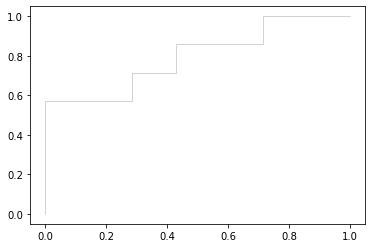

In [195]:
curr_df = pred_df_bv[pred_df_bv['shuff_num'] == 'bv_res']
plt.plot(curr_df['fpr'].values, curr_df['tpr'].values, color="grey", label='', lw=0.5, alpha=0.7)

In [323]:
dict_roc = {'bv': pred_df_bv}
roc_path = top_path + str(predict_group_size - 1) + 'first_days_predict_bv.xlsx'
paga_res.save_excel(roc_path, dict_roc)
print(str(predict_group_size - 1))

#### t-test

<AxesSubplot:title={'center':'median'}, xlabel='bv_next'>

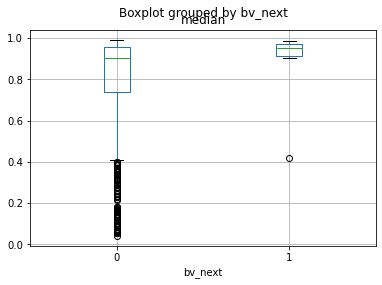

In [302]:
agg_df.boxplot(by = 'bv_next', column = 'median')

<AxesSubplot:title={'center':'std'}, xlabel='bv_next'>

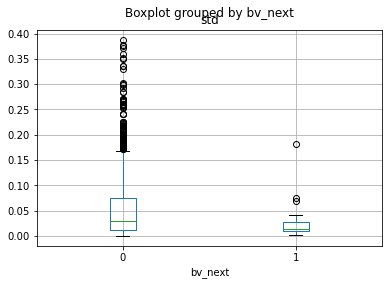

In [252]:
agg_df.boxplot(by = 'bv_next', column = 'std')